In [ ]:
import tensorflow as tf

In [13]:
from absl import flags
import sys
sys.argv = sys.argv[:1]
FLAGS = flags.FLAGS
FLAGS(sys.argv)

import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from yolov3_tf2.models import YoloV3
from yolov3_tf2.dataset import transform_images
from yolov3_tf2.utils import convert_boxes

from deep_sort import preprocessing
from deep_sort import nn_matching
from deep_sort.detection import Detection
from deep_sort.tracker import Tracker
from tools import generate_detections as gdet

In [42]:
max_cosine_distance = 0.5
nn_budget = None
nms_max_overlap = 0.8

model_filename = 'model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename, batch_size=1)
metric = nn_matching.NearestNeighborDistanceMetric('cosine', max_cosine_distance, nn_budget)
tracker = Tracker(metric)

In [ ]:
vid = cv2.VideoCapture('./data/video/foot-5frames.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results-5frames.mp4', codec, vid_fps, (vid_width, vid_height))

In [ ]:
#import cv2
#import math

#video_path = './data/video/foot.mp4'
#cap = cv2.VideoCapture(video_path)
#fps = cap.get(cv2.CAP_PROP_FPS)
#frames_to_capture = int(1 * fps)

#fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#out = cv2.VideoWriter('./data/video/foot-5frames.mp4', fourcc, fps, (int(cap.get(3)), int(cap.get(4))))

#for i in range(5):
#   ret, frame = cap.read()
#   if ret:
#       out.write(frame)
#   else:
#       break

#cap.release()
#out.release()



In [ ]:
#import cv2

#video_path = './data/video/foot-1sec.mp4'
#cap = cv2.VideoCapture(video_path)

#i = 1
#while True:
#    ret, frame = cap.read()
#    if not ret:
#        break
#    cv2.imwrite(f"./data/video/frames/image{i}.png", frame)
#    i += 1

#cap.release()


In [ ]:
#!cd {'./labelimg'} && python labelImg.py

In [ ]:
def detect_fn(img_in):
    bboxes, sscores, classes, nums = yolo.predict(img_in)

    classes = classes[0]
    names = []
    for i in range(len(classes)):
        names.append(class_names[int(classes[i])])
    names = np.array(names)
    boxes=bboxes[0]
    scores=sscores[0]
    return(boxes,scores,names)

In [ ]:
import xml.etree.ElementTree as ET
def detect_fn1(i):
    xml_file=f"./data/video/frames/image{i}.xml"
    tree = ET.parse(xml_file)
    root = tree.getroot()
    size = root.find('size')
    width = int(size.find('width').text)
    height = int(size.find('height').text)

    boxes = []
    names = []

    for object in root.iter('object'):
        # Extract and normalize bounding box coordinates
        bndbox = object.find('bndbox')
        xmin = float(bndbox.find('xmin').text) / width
        ymin = float(bndbox.find('ymin').text) / height
        xmax = float(bndbox.find('xmax').text) / width
        ymax = float(bndbox.find('ymax').text) / height
        boxes.append([xmin, ymin, xmax, ymax])

        # Extract object name
        name = object.find('name').text
        names.append(name)

    # Convert lists to numpy arrays
    boxes_array = np.array(boxes, dtype=float)
    names_array = np.array(names, dtype='<U9')
    scores_array = np.ones(len(boxes_array))

    return boxes_array, scores_array, names_array

In [ ]:
all_frames_data = []
i=1
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []
    img_in = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_in = tf.expand_dims(img_in, 0)
    img_in = transform_images(img_in, 416)

    t1 = time.time()

    boxes, scores, names= detect_fn1(i)
    allowed_classes=['player']
    deleted_indx = []
    for j in range(len(boxes)):
        if not (names[j] in allowed_classes):
            deleted_indx.append(j)
    boxes = np.delete(boxes, deleted_indx, axis=0)
    names = np.delete(names, deleted_indx, axis=0)
    scores = np.delete(scores, deleted_indx, axis=0)
    i+=1
    converted_boxes = convert_boxes(img, boxes)
    features = encoder(img, converted_boxes)



    
    detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in
                   zip(converted_boxes, scores, names, features)]
    boxs = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.class_name for d in detections])
    indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]
    tracker.predict()
    tracker.update(detections)

    #cmap = plt.get_cmap('tab20b')
    #colors = [cmap(i)[:3] for i in np.linspace(0,1,20)]

    current_count = int(0)

    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue
        
        bbox = track.to_tlbr()
        class_name= track.get_class()
        #color = colors[int(track.track_id) % len(colors)]
        #color = [i * 255 for i in color]

        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), 2)
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                    +len(str(track.track_id)))*17, int(bbox[1])), -1)
        cv2.putText(img, class_name+"-"+str(track.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    (255, 255, 255), 2)


        object_data = {
            "box": track.to_tlbr(),
            "id": track.track_id,
            "class": track.get_class()
        }

        frame_objects.append(object_data)

    all_frames_data.append(frame_objects)
        
    fps = 1./(time.time()-t1)
    cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    #cv2.resizeWindow('output', 1024, 768)
    #cv2.imshow('output', img)
    out.write(img)

    #if cv2.waitKey(1) == ord('q'):
    #    break
vid.release()
out.release()
cv2.destroyAllWindows()

#all_frames_data

In [ ]:
import cv2
import matplotlib.pyplot as plt

def display_video_frames(video_path):
    # Capture the video from the file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    frame_count = 0

    # Read until video is completed
    while cap.isOpened():
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret:
            frame_count += 1
            # Convert the frame from BGR (OpenCV default) to RGB
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(20,20))
            # Display the resulting frame
            plt.imshow(frame_rgb)
            plt.title(f"Frame {frame_count}")
            plt.axis('off')
            plt.show()

        else:
            break

    # Release the video capture object
    cap.release()

#display_video_frames('./data/video/results-5frames.mp4')


In [ ]:
import cv2
import numpy as np
i=3
img=cv2.imread(f"./data/video/frames/image{i}.png")
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
frame=all_frames_data[i-1]

In [ ]:
img=res
colors=[]
for i in range(len(frame)):
    object=frame[i]
    bbox=object['box']
    bbox_int = bbox.astype(int)
    # Extract each coordinate
    xmin, ymin, xmax, ymax = bbox_int
    # Extract the region of interest (ROI) using integer coordinates
    player_region = img[ymin:ymax, xmin:xmax]
    average_color = player_region.mean(axis=(0, 1))
    colors.append(average_color)
    plt.imshow(player_region)
    plt.show()
colors  

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming 'colors' is a list of average color values of players
# Each color is a list or array of [R, G, B] values
colors = np.array(colors)  # Convert to NumPy array for sklearn

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, n_init=10, random_state=0).fit(colors)
labels = kmeans.labels_  # Get cluster labels for each player


In [ ]:
labels

In [ ]:
for i in range(len(frame)):
    object=frame[i]
    label=labels[i]
    bbox=object['box']
    bbox_int = bbox.astype(int)
    # Extract each coordinate
    xmin, ymin, xmax, ymax = bbox_int
    # Extract the region of interest (ROI) using integer coordinates
    player_region = img[ymin:ymax, xmin:xmax]
    print(label)
    plt.imshow(player_region)
    plt.show()

In [ ]:
import cv2
import numpy as np

# Load the image
image = img

# Convert to HSV color space
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define range of green color in HSV
lower_green = np.array([40,40, 40])
upper_green = np.array([70, 255, 255])

# Create a binary mask for green color
mask = cv2.inRange(hsv, lower_green, upper_green)

# Optional: Apply the mask to the image (setting green areas to black)
result = cv2.bitwise_and(image, image, mask=~mask)
res=result
res_bgr = cv2.cvtColor(res,cv2.COLOR_HSV2BGR)
res_gray = cv2.cvtColor(res,cv2.COLOR_BGR2GRAY)
kernel = np.ones((13,13),np.uint8)
thresh = cv2.threshold(res_gray,127,255,cv2.THRESH_BINARY_INV |  cv2.THRESH_OTSU)[1]
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# Now, when processing player regions, use the mask to exclude green areas
plt.imshow(result)
plt.show()

In [ ]:
import cv2
import numpy as np

# Load the image
image = img

# Assuming 'bbox' is the bounding box with format [xmin, ymin, xmax, ymax]
bbox = [750, 650, 1100, 750]  # Replace with your actual values
bbox = np.array(bbox).astype(int)
xmin, ymin, xmax, ymax = bbox

# Extract the grass region
grass_region = image[ymin:ymax, xmin:xmax]

# Convert to HSV color space
hsv_grass = cv2.cvtColor(grass_region, cv2.COLOR_BGR2HSV)

# Analyze the hue channel to find the range of green
hue_channel = hsv_grass[:,:,0]
hist = cv2.calcHist([hue_channel], [0], None, [180], [0, 180])
threshold = 0.1 * np.max(hist)
# Assuming green hues are dominant, find the min and max green hues
green_min = np.min(np.where(hist > threshold)[0])  # Set an appropriate threshold
green_max = np.max(np.where(hist > threshold)[0])

sat_min, sat_max = 50, 255  # Adjust these based on your image
val_min, val_max = 50, 255  # Adjust these based on your image

# Define lower and upper bounds for green color in HSV
lower_green = np.array([green_min, sat_min, val_min])
upper_green = np.array([green_max, sat_max, val_max])

# Create a binary mask for green color
mask = cv2.inRange(hsv, lower_green, upper_green)

# Optional: Apply the mask to the image (setting green areas to black)
result = cv2.bitwise_and(image, image, mask=~mask)

# Now, when processing player regions, use the mask to exclude green areas
plt.imshow(result)
plt.show()

In [ ]:
import xml.etree.ElementTree as ET
img=cv2.imread('/Users/fadijemmali/Desktop/Tracker/data/video/images/test/0a2d9b_0_mp4-7_jpg.rf.73408f6d696dcacdca10265bd3623f68.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
xml_file='/Users/fadijemmali/Desktop/Tracker/data/video/images/test/0a2d9b_0_mp4-7_jpg.rf.73408f6d696dcacdca10265bd3623f68.xml'
tree = ET.parse(xml_file)
root = tree.getroot()
size = root.find('size')
width = int(size.find('width').text)
height = int(size.find('height').text)

frame=[]


for object in root.iter('object'):
    # Extract and normalize bounding box coordinates
    bndbox = object.find('bndbox')
    xmin =int( bndbox.find('xmin').text)
    ymin =int( bndbox.find('ymin').text)
    xmax =int( bndbox.find('xmax').text) 
    ymax =int( bndbox.find('ymax').text) 
    bbox=np.array([xmin, ymin, xmax, ymax])
    name = object.find('name').text
    object_data = {
            "box": bbox,
            "class": name,
            "score": 1.
        }
    frame.append(object_data)
plt.imshow(img)
plt.show()

In [ ]:
import cv2
import numpy as np

# Function to draw an ellipse under detected objects
def draw_ellipse(image, box, color, thickness=4):
    x_min, y_min, x_max, y_max = box
    bottom_center = (int((x_min + x_max) / 2), int(y_max))
    axes = (int((x_max - x_min) / 2), int(0.35 * (x_max - x_min)))
    #cv2.ellipse(image, bottom_center, axes, 0, -45, 235, color, thickness, cv2.LINE_4)
    #cv2.ellipse(image, bottom_center, axes, 0, 0, 360, color, thickness)
    cv2.ellipse(
        image,
        center=bottom_center,
        axes=axes,
        angle=0.0,
        startAngle=-45,
        endAngle=235,
        color=color,
        thickness=thickness,
        lineType=cv2.LINE_4
    )
# Color definitions for different objects
COLORS = {
    "ball": (255, 255, 255),      # White
    "goalkeeper": (133, 1, 1),    # Dark Red
    "player": (0, 212, 187),      # Greenish
    "referee": (0, 255, 255)      # Yellow
}
THICKNESS = 4


for object in frame:
    box = object["box"]
    class_name = object["class"]
    color = COLORS.get(class_name, (0, 0, 255))  # Default to red if class not found
    draw_ellipse(img, box, color, THICKNESS)

# Display the frame
plt.imshow(img)
plt.show()


In [ ]:
import xml.etree.ElementTree as ET
img=cv2.imread('/Users/fadijemmali/Desktop/Tracker/data/video/images/test/0a2d9b_0_mp4-21_jpg.rf.6958b09d7078567a99079c6ee1fb3ba5.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
xml_file='/Users/fadijemmali/Desktop/Tracker/data/video/images/test/0a2d9b_0_mp4-21_jpg.rf.6958b09d7078567a99079c6ee1fb3ba5.xml'
tree = ET.parse(xml_file)
root = tree.getroot()
size = root.find('size')
width = int(size.find('width').text)
height = int(size.find('height').text)

frame=[]


for object in root.iter('object'):
    # Extract and normalize bounding box coordinates
    bndbox = object.find('bndbox')
    xmin =int( bndbox.find('xmin').text)
    ymin =int( bndbox.find('ymin').text)
    xmax =int( bndbox.find('xmax').text) 
    ymax =int( bndbox.find('ymax').text) 
    bbox=np.array([xmin, ymin, xmax, ymax])
    name = object.find('name').text
    object_data = {
            "box": bbox,
            "class": name,
            "score": 1.
        }
    frame.append(object_data)

In [ ]:
PLAYER_IN_POSSESSION_PROXIMITY = 30
MARKER_WIDTH = 10
MARKER_HEIGHT = 10
MARKER_MARGIN = 20
PLAYER_MARKER_COLOR = (0, 0, 255)  # Red in BGR
BALL_MARKER_COLOR = (0, 255, 0)  # Green in BGR
MARKER_CONTOUR_COLOR = (0, 0, 0)  # Black in BGR
MARKER_CONTOUR_THICKNESS = 1

def calculate_marker(anchor):
    x, y = anchor
    return np.array([
        [x - MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN],
        [x, y - MARKER_MARGIN],
        [x + MARKER_WIDTH // 2, y - MARKER_HEIGHT - MARKER_MARGIN]
    ], np.int32)

def draw_marker(image, anchor, color):
    marker_contour = calculate_marker(anchor)
    cv2.fillPoly(image, [marker_contour], color)
    cv2.polylines(image, [marker_contour], isClosed=True, color=MARKER_CONTOUR_COLOR, thickness=MARKER_CONTOUR_THICKNESS)

def get_player_in_possession(players, ball):
    if len(ball) != 1:
        return None
    ball_x, ball_y = ball[0]['center']
    for player in players:
        player_x, player_y = player['center']
        if abs(player_x - ball_x) <= PLAYER_IN_POSSESSION_PROXIMITY and abs(player_y - ball_y) <= PLAYER_IN_POSSESSION_PROXIMITY:
            return player

for object in frame:
    x_min, y_min, x_max, y_max = object['box']
    object['center']=[(x_min+x_max)//2, (y_min+y_max)//2]

players = [det for det in frame if det['class'] == 'player']
ball = [det for det in frame if det['class'] == 'ball']
player_in_possession = get_player_in_possession(players, ball)
img2=img.copy()
if player_in_possession:
    draw_marker(img2, player_in_possession['center'], PLAYER_MARKER_COLOR)
for b in ball:
    draw_marker(img2, b['center'], BALL_MARKER_COLOR)
plt.figure(figsize=(20, 15))
plt.imshow(img2)
plt.axis('off')
plt.show()


In [ ]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [ ]:
model_path='/Users/fadijemmali/Desktop/Tracker/faster_rcnn_inception_resnet_v2_1024x1024/export'
configs = config_util.get_configs_from_pipeline_file(os.path.join(model_path,'pipeline.config'))
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)

# Load the latest checkpoint
latest_ckpt = tf.train.latest_checkpoint(os.path.join(model_path,'checkpoint'))
if latest_ckpt:
    ckpt.restore(latest_ckpt).expect_partial()
    print(f"Checkpoint loaded: {latest_ckpt}")
else:
    raise FileNotFoundError("No checkpoint found in", os.path.join(model_path,'checkpoint'))

@tf.function
def rcnn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [ ]:
labels = [{'name':'ball', 'id':1}, {'name':'goalkeeper', 'id':2},{'name':'player', 'id':3},{'name':'referee', 'id':4}]

with open('label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')
     

In [ ]:
category_index = label_map_util.create_category_index_from_labelmap('label_map.pbtxt')
category_index

In [ ]:
img=cv2.imread('/Users/fadijemmali/Desktop/Tracker/data/video/images/test/0a2d9b_0_mp4-21_jpg.rf.6958b09d7078567a99079c6ee1fb3ba5.jpg')
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = rcnn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.figure(figsize=(20, 15))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
folder_path = '/Users/fadijemmali/Desktop/Tracker/data/video/images/test'

files_ = sorted([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
current=1
i=20
IMAGE_PATH = os.path.join(folder_path, files_[2*i])
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = rcnn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
            for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes']+label_id_offset,
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          min_score_thresh=.6,
          agnostic_mode=False)
plt.figure(figsize=(20, 20))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
#import xml.etree.ElementTree as ET
#import os

## Directory containing your XML files
#folder_path = '/Users/fadijemmali/Desktop/Tracker/data/images/train'

## Labels to be replaced with 'person'
#labels_to_replace = ['player', 'goalkeeper', 'referee']

## Iterate over each file in the folder
#for filename in os.listdir(folder_path):
#    if filename.endswith('.xml'):
#        # Construct the full file path
#        xml_file_path = os.path.join(folder_path, filename)

#        # Load the XML file
#        tree = ET.parse(xml_file_path)
#        root = tree.getroot()

#        # Iterate over each object and update the label if it matches the criteria
#        for object_tag in root.findall('.//object'):
#            name_tag = object_tag.find('name')
#            if name_tag is not None and name_tag.text in labels_to_replace:
#                name_tag.text = 'person'

#        # Save the changes back to the XML file
#        tree.write(xml_file_path)

#        print(f"Updated labels in {xml_file_path}")

#print("All XML files have been updated.")


In [ ]:
#TRAIN_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'train')
#TEST_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'test')
#ARCHIVE_PATH = os.path.join('Tensorflow', 'workspace', 'images', 'archive2.tar.gz')
#!tar -czf {ARCHIVE_PATH} {TRAIN_PATH} {TEST_PATH}

In [ ]:
def detect_fn2(img, threshold=0.1):
    image_np = np.array(img)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = rcnn(input_tensor)
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections
    
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    boxes = detections['detection_boxes']
    boxes = boxes[:, [1, 0, 3, 2]]  # Rearranging box coordinates
    scores = detections['detection_scores']
    classes = detections['detection_classes']

    ## Filter out detections with scores less than the threshold
    keep = scores > threshold
    boxes = boxes[keep]
    scores = scores[keep]
    classes = classes[keep]

    # Process class names
    class_names = ['person' if category_index[class_id + 1]['name'] in ['player', 'goalkeeper', 'referee'] else category_index[class_id + 1]['name'] for class_id in classes]
    
    return boxes, scores, class_names

In [ ]:
img=cv2.imread('/Users/fadijemmali/Desktop/Tracker/data/video/images/test/0a2d9b_0_mp4-21_jpg.rf.6958b09d7078567a99079c6ee1fb3ba5.jpg')
print(detect_fn2(img))

In [ ]:
vid = cv2.VideoCapture('./data/video/red_white.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
#out = cv2.VideoWriter('./data/video/results-red_white.mp4', codec, vid_fps, (vid_width, vid_height))

In [ ]:
vid = cv2.VideoCapture('./data/video/red_white.mp4')
all_detection_data = []
current=1
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []

    boxes, scores, names= detect_fn2(img)

    for i in range(len(boxes)):
            object_data = {
                "box":boxes[i],
                "score": scores[i],
                "class": names[i]
            }
    
            frame_objects.append(object_data)

    all_detection_data.append(frame_objects)
        
    print(f"frame{current} done")
    current+=1

vid.release()

In [ ]:
all_frames_data = []
current=1
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []

    t1 = time.time()

    boxes, scores, names= detect_fn2(img)
    #allowed_classes=['player']
    #deleted_indx = []
    #for j in range(len(boxes)):
    #    if not (names[j] in allowed_classes):
    #        deleted_indx.append(j)
    #boxes = np.delete(boxes, deleted_indx, axis=0)
    #names = np.delete(names, deleted_indx, axis=0)
    #scores = np.delete(scores, deleted_indx, axis=0)

    converted_boxes = convert_boxes(img, boxes)
    features = encoder(img, converted_boxes)



    
    detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in
                   zip(converted_boxes, scores, names, features)]
    boxs = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.class_name for d in detections])
    indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]
    tracker.predict()
    tracker.update(detections)

    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i)[:3] for i in np.linspace(0,1,20)]

    current_count = int(0)

    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue
        
        bbox = track.to_tlbr()
        class_name= track.get_class()
        color = colors[int(track.track_id) % len(colors)]
        color = [i * 255 for i in color]

        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color, 2)
        cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
                    +len(str(track.track_id)))*17, int(bbox[1])),color, -1)
        cv2.putText(img, class_name+"-"+str(track.track_id), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    (255, 255, 255), 2)


        object_data = {
            "box": track.to_tlbr(),
            "id": track.track_id,
            "class": track.get_class()
        }

        frame_objects.append(object_data)

    all_frames_data.append(frame_objects)
        
    fps = 1./(time.time()-t1)
    cv2.putText(img, "FPS: {:.2f}".format(fps), (0,30), 0, 1, (0,0,255), 2)
    #cv2.resizeWindow('output', 1024, 768)
    #cv2.imshow('output', img)
    
    #out.write(img)

    #if cv2.waitKey(1) == ord('q'):
    #    break
    print(f"frame{current} done")
    current+=1

vid.release()

#out.release()
#cv2.destroyAllWindows()

#all_frames_data

In [ ]:
%matplotlib inline
vid = cv2.VideoCapture('./data/video/red_yellow.mp4')
i=300
vid.set(cv2.CAP_PROP_POS_FRAMES, i)

_, img = vid.read()


image_np = np.array(img)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = rcnn(input_tensor)
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
            for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes']+label_id_offset,
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          min_score_thresh=.6,
          agnostic_mode=False)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

vid.release()
cv2.destroyAllWindows()


In [ ]:
%matplotlib inline
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    boxes,scores,classes=detect_fn2(img)
    
    
    threshold = 0.5

    for i in range(len(scores)):
        if scores[i] > threshold:
            # Box coordinates
            xmin, ymin, xmax, ymax = boxes[i]
    
            # Rescale box coordinates to the original image size
            (left, right, top, bottom) = (xmin * img.shape[1], xmax * img.shape[1],
                                          ymin * img.shape[0], ymax * img.shape[0])
    
            # Draw rectangle
            img = cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (0, 255, 0), 2)
    
            # Optionally, include class label and score
            label = f'Class: {classes[i]}, Score: {scores[i]:.2f}'
            img = cv2.putText(img, label, (int(left), int(top-10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    break



In [70]:
def count_nonblack_np(img):
    """Return the number of pixels in img that are not black.
    img must be a Numpy array with colour values along the last axis.

    """
    return img.any(axis=-1).sum()
def red(image):
    
    # Convert the image from BGR to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Define lower and upper range of yellow in HSV
    lower_red1 = np.array([0, 120, 70])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([170, 120, 70])
    upper_red2 = np.array([180, 255, 255])
   
    mask_red1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
    mask_red2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
    
    # Combine masks
    full_mask_red = cv2.bitwise_or(mask_red1, mask_red2)
    red_regions = cv2.bitwise_and(image, image, mask=full_mask_red)
    
    tot_pix = count_nonblack_np(image)
    color_pix = count_nonblack_np(red_regions)
    ratio = color_pix/tot_pix
    
    return ratio
    
def green(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_green = np.array([40, 40, 40])  # Lower bound of light green
    upper_green = np.array([70, 255, 255])  # Upper bound of light green
    
    # Create masks for the yellow range
    mask_green = cv2.inRange(hsv_image, lower_green, upper_green)
    
    green_regions = cv2.bitwise_and(image, image, mask=mask_green)
    
    tot_pix = count_nonblack_np(image)
    color_pix = count_nonblack_np(green_regions)
    ratio = color_pix/tot_pix
    return ratio
def yellow(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])
    
    # Create masks for the yellow range
    mask_yellow = cv2.inRange(hsv_image, lower_yellow, upper_yellow)
    
    yellow_regions = cv2.bitwise_and(image, image, mask=mask_yellow)
    
    tot_pix = count_nonblack_np(image)
    color_pix = count_nonblack_np(yellow_regions)
    ratio = color_pix/tot_pix
    
    return ratio

def white(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define the range for white color
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 55, 255])

    # Create masks for the white range
    mask_white = cv2.inRange(hsv_image, lower_white, upper_white)
    
    white_regions = cv2.bitwise_and(image, image, mask=mask_white)
    
    tot_pix = count_nonblack_np(image)
    color_pix = count_nonblack_np(white_regions)
    ratio = color_pix / tot_pix
    
    
    return ratio

In [ ]:
import json
import numpy as np

# Specify the file name
file_name = "/Users/fadijemmali/Desktop/Tracker/data/all_frames_data3.json"
def convert_to_serializable(data):
   if isinstance(data, np.ndarray):
        return data.tolist()
   elif isinstance(data, list):
        return [convert_to_serializable(item) for item in data]
   elif isinstance(data, dict):
        return {key: convert_to_serializable(value) for key, value in data.items()}
   else:
        return data

# Convert all ndarrays to lists
serializable_data = convert_to_serializable(all_frames_data)

with open(file_name, 'w') as file:
    json.dump(serializable_data, file, indent=4)

In [ ]:
import cv2
import numpy as np
%matplotlib inline

vid = cv2.VideoCapture('./data/video/red_yellow.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results-red_yellow.mp4', codec, vid_fps, (vid_width, vid_height))
for frame in data:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for object in frame:
        xmin, ymin, xmax, ymax = object['box']
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        crop_img = img[ymin:ymax, xmin:xmax]
        if crop_img.size > 0:
            class_name= object['class']
            id=object['id']
            if class_name=='person':
                if red(crop_img):
                    object['class']='team1'
                elif yellow(crop_img):
                    object['class']='team2'
    #persons=[obj for obj in frame if obj['class'] == 'person']
    #team1=[obj for obj in frame if obj['class'] == 'team1']
    #team2=[obj for obj in frame if obj['class'] == 'team2']
    #balls=[obj for obj in frame if obj['class'] == 'ball']
    
    last_id_per_class = {}
    color_dict = {
    "team1": (0, 0, 255),    # Red color for team1 (BGR format)
    "team2": (0, 255, 255),    # yellow color for team2
    "person": (255, 0, 255), # Purple color for person (mix of red and blue)
    "ball": (255, 255, 255)  # White color for ball
    }


    for obj in frame:
        class_name = obj['class']

        #if class_name not in last_id_per_class:
        #    last_id_per_class[class_name] = 1
        #else:
        #    # If class is already in dictionary, increment the last ID
        #    last_id_per_class[class_name] += 1

        ## Assign the new ID to the object
        #new_id = last_id_per_class[class_name]
        #obj['id'] = new_id
        bbox=obj['box']
        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color_dict[obj['class']], 2)
        #cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
        #            +len(str(id)))*17, int(bbox[1])),color, -1)
        if obj['class']=='person' or obj['class']=='ball'  :
            cv2.putText(img, obj['class'], (int(bbox[0]), int(bbox[1]-10)), 0, 0.4,
                    color_dict[obj['class']], 1)
        else:
            cv2.putText(img,'player' + str(obj['id']), (int(bbox[0]), int(bbox[1]-10)), 0, 0.4,
                    color_dict[obj['class']], 1)

    out.write(img)

    #if cv2.waitKey(1) == ord('q'):
    #    break

                
vid.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

vid = cv2.VideoCapture('./data/video/results-red_green.mp4')
for frame in data:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
vid.release()
out.release()
cv2.destroyAllWindows()

In [ ]:
import json

# Load from JSON file
file_name = "/Users/fadijemmali/Desktop/Tracker/data/all_frames_data3.json"
with open(file_name, 'r') as file:
    all_frames_data = json.load(file)

# Now loaded_data contains the data from the JSON file

data=all_frames_data.copy()
#data

In [ ]:
import cv2
import numpy as np
from collections import defaultdict, Counter
%matplotlib inline
vid = cv2.VideoCapture('./data/video/red_white.mp4')

for frame in data:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for obj in frame:
        xmin, ymin, xmax, ymax = obj['box']
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        crop_img = img[ymin:ymax, xmin:xmax]
        if crop_img.size > 0:
            class_name= obj['class']
            id=obj['id']
            if class_name=='person':
                if red(crop_img)>0.05 or white(crop_img)>0.05:
                    if red(crop_img)>white(crop_img):
                        obj['class']='team1'
                    else:
                        obj['class']='team2'
                    
    #persons=[obj for obj in frame if obj['class'] == 'person']
    #team1=[obj for obj in frame if obj['class'] == 'team1']
    #team2=[obj for obj in frame if obj['class'] == 'team2']
    #balls=[obj for obj in frame if obj['class'] == 'ball']
    
    last_id_per_class = {}
    color_dict = {
    "team1": (0, 0, 255),    # Red color for team1 (BGR format)
    "team2": (0, 255, 255),    # yellow color for team2
    "person": (255, 0, 255), # Purple color for person (mix of red and blue)
    "ball": (255, 255, 255)  # White color for ball
    }
vid.release()

vid = cv2.VideoCapture('./data/video/red_white.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results-red_white.mp4', codec, vid_fps, (vid_width, vid_height))


labels_per_id = defaultdict(list)

for frame in data:  # Iterate over each frame
    for obj in frame:  # Iterate over each detection in the frame
        if obj['id'] == 20:
            obj['class']='person'
        player_id = obj['id']
        label = obj['class']
        labels_per_id[player_id].append(label)

# Dictionary to store the most common label for each ID
most_common_label_per_id = {}

for player_id, labels in labels_per_id.items():
    # Determine the most common label
    most_common_label = Counter(labels).most_common(1)[0][0]
    most_common_label_per_id[player_id] = most_common_label


new_id_mapping = defaultdict(lambda: defaultdict(int))

for old_id, label in most_common_label_per_id.items():
    # Increment the counter for the label and assign the new ID
    new_id_mapping[label]['counter'] += 1
    new_id_mapping[label][old_id] = new_id_mapping[label]['counter']

def get_new_id(old_id, label):
    """
    Given an old ID and its label, returns a new ID that is unique within the label category.
    """
    return new_id_mapping[label][old_id]

for frame in data:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for obj in frame:
        id = obj['id']
        # Assign the most common label to this detection
        obj['class'] = most_common_label_per_id[id]
        class_name = obj['class']
        obj['id']=get_new_id(obj['id'],obj['class'])
        bbox=obj['box']
        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color_dict[obj['class']], 2)
        #cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
        #            +len(str(id)))*17, int(bbox[1])),color, -1)
        if obj['class']=='person' or obj['class']=='ball'  :
            cv2.putText(img, obj['class'], (int(bbox[0]), int(bbox[1]-10)), 0, 0.4,
                    color_dict[obj['class']], 2)
        else:
            cv2.putText(img,'player' + str(obj['id']), (int(bbox[0]), int(bbox[1]-10)), 0, 0.4,
                    color_dict[obj['class']], 2)

    out.write(img)

    #if cv2.waitKey(1) == ord('q'):
    #    break

                
vid.release()
out.release()

In [ ]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current Directory:", current_directory)

In [ ]:
!pip install -r yolov5/requirements.txt

In [ ]:
!python yolov5/detect.py --weights best.pt --img 1280 --conf 0.25 --source data/video/red_white.mp4 --name custom

In [1]:
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
from yolov3_tf2.utils import convert_boxes
%matplotlib inline

In [2]:
import torch
WEIGHTS_PATH = "best.pt"
model = torch.hub.load('ultralytics/yolov5', 'custom', WEIGHTS_PATH, device='cpu')

Using cache found in /Users/fadijemmali/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-12-25 Python-3.9.18 torch-2.1.0 CPU

Fusing layers... 
Model summary: 416 layers, 139999708 parameters, 0 gradients, 207.9 GFLOPs
Adding AutoShape... 


In [3]:
model.conf = 0.05

In [4]:
def detect_fn3(img):
    height, width = img.shape[:2]

    res= model(img, size=1280)
    detections = res.pred[0]

    # Extract bounding boxes, scores, and class IDs
    boxes = detections[:, :4].numpy()  # x_center, y_center, width, height
    scores = detections[:, 4].numpy()
    class_ids = detections[:, 5].int().numpy()
    
    # Convert class IDs to class names
    class_names = [model.names[i] for i in class_ids]


    normalized_boxes = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        x_min_normalized = x_min / width
        y_min_normalized = y_min / height
        x_max_normalized = x_max / width
        y_max_normalized = y_max / height
        normalized_boxes.append([x_min_normalized, y_min_normalized, x_max_normalized, y_max_normalized])

    return(np.array(normalized_boxes),scores,class_names,class_ids)

In [58]:
vid = cv2.VideoCapture('./data/video/red_white.mp4')
all_detection_data = []
current=1
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []

    boxes, scores, names, class_ids= detect_fn3(img)

    for i in range(len(boxes)):
            object_data = {
                "box":boxes[i],
                "score": scores[i],
                "class": names[i]
            }
    
            frame_objects.append(object_data)

    all_detection_data.append(frame_objects)
        
    print(f"frame{current} done")
    current+=1

vid.release()

frame1 done
frame2 done
frame3 done
frame4 done
frame5 done
frame6 done
frame7 done
frame8 done
frame9 done
frame10 done
frame11 done
frame12 done
frame13 done
frame14 done
frame15 done
frame16 done
frame17 done
frame18 done
frame19 done
frame20 done
frame21 done
frame22 done
frame23 done
frame24 done
frame25 done
frame26 done
frame27 done
frame28 done
frame29 done
frame30 done
frame31 done
frame32 done
frame33 done
frame34 done
frame35 done
frame36 done
frame37 done
frame38 done
frame39 done
frame40 done
frame41 done
frame42 done
frame43 done
frame44 done
frame45 done
frame46 done
frame47 done
frame48 done
frame49 done
frame50 done
frame51 done
frame52 done
frame53 done
frame54 done
frame55 done
frame56 done
frame57 done
frame58 done
frame59 done
frame60 done
frame61 done
frame62 done
frame63 done
frame64 done
frame65 done
frame66 done
frame67 done
frame68 done
frame69 done
frame70 done
frame71 done
frame72 done
frame73 done
frame74 done
frame75 done
frame76 done
frame77 done
frame78 

In [59]:
all_data=[]
ball_data=[]
for frame in all_detection_data:
    all=[]
    ball=[]
    for object in frame:
        if object['class']=='ball':
            ball.append(object)
        else:
            all.append(object)
    all_data.append(all)
    ball_data.append(ball)    

In [60]:
# Iterate through each frame in your ball_data array
for i, frame in enumerate(ball_data):
    # Check if there is more than one ball detection in the frame
    if len(frame) > 1:
        # Find the detection with the highest score
        highest_score_detection = max(frame, key=lambda detection: detection['score'])
        
        # Keep only the detection with the highest score
        ball_data[i] = [highest_score_detection]

# Now, ball_data will contain only the ball with the highest score in frames with multiple detections


In [61]:
# Initialize a counter for frames with no ball detections
no_detection_count = 0

# Total number of frames
total_frames = len(ball_data)

# Iterate through each frame in your ball_data array
for frame in ball_data:
    # Check if there are no ball detections in the frame
    if len(frame) == 0:
        no_detection_count += 1

# Calculate the percentage of frames with no ball detections
no_detection_percentage = (no_detection_count / total_frames) * 100

# Print or return the percentage
print(f"Percentage of frames with no ball detections: {no_detection_percentage}%")


Percentage of frames with no ball detections: 29.333333333333332%


In [62]:
from strong_sort.utils.parser import get_config
from strong_sort.strong_sort import StrongSORT
from strong_sort.sort.tracker import Tracker

In [63]:
strong_sort_weights='weights/osnet_x0_25_msmt17.pt'
tracker= StrongSORT(model_weights= strong_sort_weights,
                 device='cpu',
                 fp16=False,
                 max_dist=0.2,
                 max_iou_distance=0.7,
                 max_age=70, n_init=3,
                 nn_budget=100,
                 mc_lambda=0.995,
                 ema_alpha=0.9
                )

Model: osnet_x0_25
- params: 203,568
- flops: 82,316,000
Successfully loaded pretrained weights from "weights/osnet_x0_25_msmt17.pt"
** The following layers are discarded due to unmatched keys or layer size: ['classifier.weight', 'classifier.bias']


In [ ]:
# Your label map
labels = [
    {'name': 'ball', 'id': 1},
    {'name': 'goalkeeper', 'id': 2},
    {'name': 'player', 'id': 3},
    {'name': 'referee', 'id': 4}
]

# Convert label map to a dictionary for easy lookup
label_dict = {item['name']: item['id'] for item in labels}


for frame in all_data:
    for detection in frame:
        class_name = detection['class']
        class_id = label_dict.get(class_name)
        detection['class_id'] = class_id

# all_data now has 'class_id' in each detection
all_data


In [80]:
vid = cv2.VideoCapture('./data/video/red_white.mp4')
all_frames_data = []
current=0

    
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []

    t1 = time.time()
    
    boxes, scores, names, class_ids= [] , [], [], []
    for obj in all_data[current]:
        if obj['score']>0.6:
            boxes.append(obj['box'])
            scores.append(obj['score'])
            names.append(obj['class'])
            class_ids.append(obj['class_id'])

    boxes, scores, names,class_ids= np.array(boxes), np.array(scores), np.array(names), np.array(class_ids)
    
    converted_boxes = np.array(convert_boxes(img, boxes))
    #print(converted_boxes)
    #break
    tracks=tracker.update(converted_boxes, scores, class_ids,img)


    for track in tracker.tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue
        track_id=track.track_id
        hits=track.hits
        class_name=track.class_id
        bbox = track.to_tlbr()
        #class_name= track.get_class()

        object_data = {
            "box": bbox,
            "class":class_name,
            "id": track_id
        }

        frame_objects.append(object_data)

    all_frames_data.append(frame_objects)
        
    print(f"frame{current+1} done")
    current+=1

vid.release()

frame1 done
frame2 done
frame3 done
frame4 done
frame5 done
frame6 done
frame7 done
frame8 done
frame9 done
frame10 done
frame11 done
frame12 done
frame13 done
frame14 done
frame15 done
frame16 done
frame17 done
frame18 done
frame19 done
frame20 done
frame21 done
frame22 done
frame23 done
frame24 done
frame25 done
frame26 done
frame27 done
frame28 done
frame29 done
frame30 done
frame31 done
frame32 done
frame33 done
frame34 done
frame35 done
frame36 done
frame37 done
frame38 done
frame39 done
frame40 done
frame41 done
frame42 done
frame43 done
frame44 done
frame45 done
frame46 done
frame47 done
frame48 done
frame49 done
frame50 done
frame51 done
frame52 done
frame53 done
frame54 done
frame55 done
frame56 done
frame57 done
frame58 done
frame59 done
frame60 done
frame61 done
frame62 done
frame63 done
frame64 done
frame65 done
frame66 done
frame67 done
frame68 done
frame69 done
frame70 done
frame71 done
frame72 done
frame73 done
frame74 done
frame75 done
frame76 done
frame77 done
frame78 

In [76]:
all_frames_data

[[{'box': array([       1815,         834,        1855,         936]),
   'class': 4,
   'id': 1},
  {'box': array([      996.2,      730.35,      1042.5,      824.03]),
   'class': 3,
   'id': 2},
  {'box': array([     150.94,      39.446,      160.94,      62.456]),
   'class': 4,
   'id': 3},
  {'box': array([       1347,         429,        1379,         484]),
   'class': 3,
   'id': 4},
  {'box': array([     1022.2,      359.26,      1040.1,      410.16]),
   'class': 3,
   'id': 6},
  {'box': array([     948.18,      285.15,      967.24,      324.09]),
   'class': 3,
   'id': 7},
  {'box': array([     484.37,      380.69,      503.02,      424.28]),
   'class': 3,
   'id': 8},
  {'box': array([       1465,         383,        1492,         444]),
   'class': 3,
   'id': 9},
  {'box': array([        543,         421,         568,      470.99]),
   'class': 3,
   'id': 10},
  {'box': array([     541.01,      456.01,      565.99,      516.98]),
   'class': 3,
   'id': 11},
  {'box'

In [81]:
for frame in all_frames_data:
    for detection in frame:
        xmin, ymin, xmax, ymax = detection['box']
        w=xmax-xmin
        h=ymax-ymin
        xmin, ymin, xmax, ymax = xmin+w/2, ymin+h/2, xmax+w/2, ymax+h/2
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        detection['box']=[xmin, ymin, xmax, ymax]

In [82]:
# Your label map
labels = [
    {'name': 'ball', 'id': 1},
    {'name': 'goalkeeper', 'id': 2},
    {'name': 'player', 'id': 3},
    {'name': 'referee', 'id': 4}
]

# Convert label map to a dictionary for easy lookup
id_to_name_dict = {item['id']: item['name'] for item in labels}


# Updating 'class' from class ID to class name
for frame in all_frames_data:
    for detection in frame:
        class_id = detection['class']
        class_name = id_to_name_dict.get(class_id)
        detection['class'] = class_name

# all_data now has 'class' as class name
all_frames_data


[[{'box': [1834, 884, 1874, 986], 'class': 'referee', 'id': 1},
  {'box': [754, 679, 788, 759], 'class': 'player', 'id': 2},
  {'box': [560, 369, 581, 414], 'class': 'player', 'id': 4},
  {'box': [553, 486, 578, 547], 'class': 'player', 'id': 6},
  {'box': [713, 367, 735, 418], 'class': 'player', 'id': 8},
  {'box': [1478, 413, 1505, 474], 'class': 'player', 'id': 9},
  {'box': [920, 397, 945, 450], 'class': 'player', 'id': 14},
  {'box': [1031, 384, 1049, 435], 'class': 'player', 'id': 15},
  {'box': [1613, 627, 1643, 702], 'class': 'player', 'id': 16},
  {'box': [555, 445, 580, 495], 'class': 'player', 'id': 17},
  {'box': [272, 583, 315, 641], 'class': 'player', 'id': 18},
  {'box': [1019, 777, 1065, 870], 'class': 'player', 'id': 19},
  {'box': [499, 422, 536, 478], 'class': 'player', 'id': 21},
  {'box': [691, 281, 710, 319], 'class': 'referee', 'id': 22},
  {'box': [841, 429, 860, 486], 'class': 'player', 'id': 23},
  {'box': [265, 624, 313, 686], 'class': 'player', 'id': 28},
  

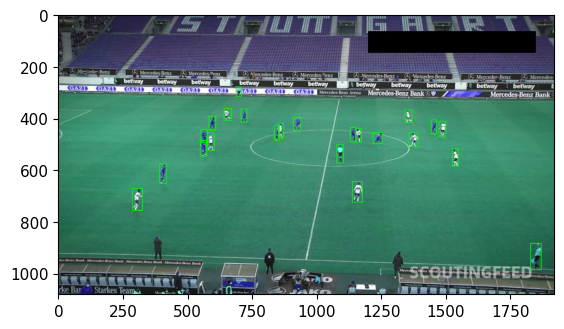

In [57]:
vid = cv2.VideoCapture('./data/video/red_white.mp4')
vid.set(cv2.CAP_PROP_POS_FRAMES, 2)
_, img = vid.read()

first_frame_data=all_frames_data[2]
height, width = img.shape[:2]

for detection in first_frame_data:
    # Unpack normalized coordinates
    xmin, ymin, xmax, ymax = detection['box']
    w=xmax-xmin
    h=ymax-ymin
    xmin, ymin, xmax, ymax = xmin+w/2, ymin+h/2, xmax+w/2, ymax+h/2
    xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
    #print( xmin, ymin, xmax, ymax)
    # Draw rectangle
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
plt.imshow(img)
plt.show()


vid.release()

In [43]:
vid = cv2.VideoCapture('./data/video/red_white.mp4')
all_frames_data = []
current=0

    
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    frame_objects = []

    t1 = time.time()
    
    boxes, scores, names= [] , [], []
    for obj in all_data[current]:
        boxes.append(obj['box'])
        scores.append(obj['score'])
        names.append(obj['class'])

    boxes, scores, names= np.array(boxes), np.array(scores), np.array(names)
    
    converted_boxes = convert_boxes(img, boxes)
    features = encoder(img, converted_boxes)



    
    detections = [Detection(bbox, score, class_name, feature) for bbox, score, class_name, feature in
                   zip(converted_boxes, scores, names, features)]
    boxs = np.array([d.tlwh for d in detections])
    scores = np.array([d.confidence for d in detections])
    classes = np.array([d.class_name for d in detections])
    indices = preprocessing.non_max_suppression(boxs, classes, nms_max_overlap, scores)
    detections = [detections[i] for i in indices]
    tracker.predict()
    tracker.update(detections)


    for track in tracker.tracks:
        if not track.is_confirmed() or track.time_since_update >1:
            continue
        
        bbox = track.to_tlbr()
        class_name= track.get_class()

        object_data = {
            "box": track.to_tlbr(),
            "id": track.track_id,
            "class": track.get_class()
        }

        frame_objects.append(object_data)

    all_frames_data.append(frame_objects)
        
    print(f"frame{current+1} done")
    current+=1

vid.release()

frame1 done
frame2 done
frame3 done
frame4 done
frame5 done
frame6 done
frame7 done
frame8 done
frame9 done
frame10 done
frame11 done
frame12 done
frame13 done
frame14 done
frame15 done
frame16 done
frame17 done
frame18 done
frame19 done
frame20 done
frame21 done
frame22 done
frame23 done
frame24 done
frame25 done
frame26 done
frame27 done
frame28 done
frame29 done
frame30 done
frame31 done
frame32 done
frame33 done
frame34 done
frame35 done
frame36 done
frame37 done
frame38 done
frame39 done
frame40 done
frame41 done
frame42 done
frame43 done
frame44 done
frame45 done
frame46 done
frame47 done
frame48 done
frame49 done


IndexError: list index out of range

In [71]:
ball_data

[[{'box': array([    0.70422,      0.4653,     0.70967,      0.4746]),
   'score': 0.05910335,
   'class': 'ball'}],
 [{'box': array([    0.70422,      0.4653,     0.70967,     0.47461]),
   'score': 0.059357706,
   'class': 'ball'}],
 [],
 [{'box': array([     0.7092,     0.46373,     0.71534,     0.47492]),
   'score': 0.084999286,
   'class': 'ball'}],
 [{'box': array([     0.7075,     0.46685,     0.71295,     0.47628]),
   'score': 0.084085345,
   'class': 'ball'}],
 [{'box': array([    0.70614,     0.46846,     0.71199,     0.47797]),
   'score': 0.65036756,
   'class': 'ball'}],
 [{'box': array([    0.70581,     0.46816,     0.71178,     0.47796]),
   'score': 0.68912965,
   'class': 'ball'}],
 [{'box': array([    0.70631,     0.46797,     0.71242,     0.47809]),
   'score': 0.6714187,
   'class': 'ball'}],
 [{'box': array([    0.70674,      0.4686,      0.7119,     0.47901]),
   'score': 0.3716337,
   'class': 'ball'}],
 [{'box': array([    0.70654,     0.46842,     0.71126,   

In [ ]:
import json
import numpy as np

# Specify the file name
file_name = "/Users/fadijemmali/Desktop/Tracker/data/red_white_tracking_rcnn_data.json"
def convert_to_serializable(data):
   if isinstance(data, np.ndarray):
        return data.tolist()
   elif isinstance(data, list):
        return [convert_to_serializable(item) for item in data]
   elif isinstance(data, dict):
        return {key: convert_to_serializable(value) for key, value in data.items()}
   else:
        return data

# Convert all ndarrays to lists
serializable_data = convert_to_serializable(all_frames_data)

with open(file_name, 'w') as file:
    json.dump(serializable_data, file, indent=4)

In [72]:
ball_data_original= ball_data
ball_data= ball_data_original.copy()
vid = cv2.VideoCapture('./data/video/red_green.mp4')

_, img = vid.read()
vid.release()
image_height, image_width = img.shape[:2]

for frame in ball_data:
    for detection in frame:
        # Extract normalized coordinates
        xmin, ymin, xmax, ymax = detection['box']

        # Convert to pixel coordinates
        xmin_pixel = int(xmin * image_width)
        ymin_pixel = int(ymin * image_height)
        xmax_pixel = int(xmax * image_width)
        ymax_pixel = int(ymax * image_height)

        # Update detection box with literal integer coordinates
        detection['box'] = [xmin_pixel, ymin_pixel, xmax_pixel, ymax_pixel]


In [73]:
ball_data

[[{'box': [1352, 502, 1362, 512], 'score': 0.05910335, 'class': 'ball'}],
 [{'box': [1352, 502, 1362, 512], 'score': 0.059357706, 'class': 'ball'}],
 [],
 [{'box': [1361, 500, 1373, 512], 'score': 0.084999286, 'class': 'ball'}],
 [{'box': [1358, 504, 1368, 514], 'score': 0.084085345, 'class': 'ball'}],
 [{'box': [1355, 505, 1367, 516], 'score': 0.65036756, 'class': 'ball'}],
 [{'box': [1355, 505, 1366, 516], 'score': 0.68912965, 'class': 'ball'}],
 [{'box': [1356, 505, 1367, 516], 'score': 0.6714187, 'class': 'ball'}],
 [{'box': [1356, 506, 1366, 517], 'score': 0.3716337, 'class': 'ball'}],
 [{'box': [1356, 505, 1365, 517], 'score': 0.37035665, 'class': 'ball'}],
 [{'box': [1355, 505, 1365, 518], 'score': 0.51212114, 'class': 'ball'}],
 [{'box': [1355, 504, 1365, 517], 'score': 0.16342478, 'class': 'ball'}],
 [{'box': [1357, 505, 1367, 518], 'score': 0.06711687, 'class': 'ball'}],
 [],
 [],
 [],
 [{'box': [1368, 527, 1378, 538], 'score': 0.2663419, 'class': 'ball'}],
 [{'box': [1371, 5

In [ ]:
import json

# Load from JSON file
file_name = "/Users/fadijemmali/Desktop/Tracker/data/red_white_tracking_rcnn_data.json"
with open(file_name, 'r') as file:
    all_frames_data = json.load(file)

# Now loaded_data contains the data from the JSON file

data=all_frames_data.copy()
#data

In [ ]:
import json


# Specify the file name
file_name = "/Users/fadijemmali/Desktop/Tracker/data/red_white_ball_rcnn_data.json"

# Writing JSON data
with open(file_name, 'w') as file:
    json.dump(ball_data, file)

print(f"Data saved to {file_name}")


In [ ]:
import json
import numpy as np

# Specify the file name
file_name = "/Users/fadijemmali/Desktop/Tracker/data/red_white_ball_rcnn_data.json"
def convert_to_serializable(data):
   if isinstance(data, np.ndarray):
        return data.tolist()
   elif isinstance(data, list):
        return [convert_to_serializable(item) for item in data]
   elif isinstance(data, dict):
        return {key: convert_to_serializable(value) for key, value in data.items()}
   else:
        return data

# Convert all ndarrays to lists
serializable_data = convert_to_serializable(ball_data)

with open(file_name, 'w') as file:
    json.dump(serializable_data, file, indent=4)

In [ ]:
import json

# Load from JSON file
file_name = "/Users/fadijemmali/Desktop/Tracker/data/red_white_tracking_rcnn_data.json"
with open(file_name, 'r') as file:
    ball_data = json.load(file)

In [85]:
data=all_frames_data.copy()
import cv2
import numpy as np
from collections import defaultdict, Counter
%matplotlib inline
vid = cv2.VideoCapture('./data/video/red_white.mp4')

for frame in data:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for obj in frame:
        xmin, ymin, xmax, ymax = obj['box']
        xmin, ymin, xmax, ymax = int(xmin), int(ymin), int(xmax), int(ymax)
        crop_img = img[ymin:ymax, xmin:xmax]
        if crop_img.size > 0:
            class_name= obj['class']
            id=obj['id']
            if class_name=='player' or class_name=='referee':
                 if red(crop_img)>0.05 or white(crop_img)>0.05:
                    if red(crop_img)>white(crop_img):
                        obj['class']='team1'
                    else:
                        obj['class']='team2'
            if obj['id']==22:
               obj['class']='referee' 
                    
    #persons=[obj for obj in frame if obj['class'] == 'person']
    #team1=[obj for obj in frame if obj['class'] == 'team1']
    #team2=[obj for obj in frame if obj['class'] == 'team2']
    #balls=[obj for obj in frame if obj['class'] == 'ball']
    
    last_id_per_class = {}
    color_dict = {
    "team1": (0, 0, 255),    # Red color for team1 (BGR format)
    "team2": (255, 255, 255),    # white
    "referee": (255,0,0), # blue
    "goalkeeper": (255, 255, 0), #yellow
    "player": (255, 255, 0), #yellow
    "ball": (0, 255, 0)  # White color for ball
    }
vid.release()

vid = cv2.VideoCapture('./data/video/red_white.mp4')

codec = cv2.VideoWriter_fourcc(*'mp4v')
vid_fps =int(vid.get(cv2.CAP_PROP_FPS))
vid_width,vid_height = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)), int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter('./data/video/results-red_white4.mp4', codec, vid_fps, (vid_width, vid_height))


labels_per_id = defaultdict(list)

for frame in data:  # Iterate over each frame
    for obj in frame:  # Iterate over each detection in the frame
        player_id = obj['id']
        label = obj['class']
        labels_per_id[player_id].append(label)

# Dictionary to store the most common label for each ID
most_common_label_per_id = {}

for player_id, labels in labels_per_id.items():
    # Determine the most common label
    most_common_label = Counter(labels).most_common(1)[0][0]
    most_common_label_per_id[player_id] = most_common_label

#for frame in data:
#    for obj in frame:
#        id = obj['id']
#        # Assign the most common label to this detection
#        obj['class'] = most_common_label_per_id[id]


#new_id_mapping = defaultdict(lambda: defaultdict(int))

#for old_id, label in most_common_label_per_id.items():
#    # Increment the counter for the label and assign the new ID
#    new_id_mapping[label]['counter'] += 1
#    new_id_mapping[label][old_id] = new_id_mapping[label]['counter']

#def get_new_id(old_id, label):
#    """
#    Given an old ID and its label, returns a new ID that is unique within the label category.
#    """
#    return new_id_mapping[label][old_id]

current=0
for frame in data:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    for obj in frame:
#        obj['id']=get_new_id(obj['id'],obj['class'])
        class_name = obj['class']

        bbox=obj['box']
        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color_dict[obj['class']], 2)
        #cv2.rectangle(img, (int(bbox[0]), int(bbox[1]-30)), (int(bbox[0])+(len(class_name)
        #            +len(str(id)))*17, int(bbox[1])),color, -1)
        if obj['class']=='referee' or obj['class']=='goalkeeper' or obj['class']=='player' :
            cv2.putText(img, obj['class'], (int(bbox[0]), int(bbox[1]-10)), 0, 0.5,
                    color_dict[obj['class']], 1)
        else:
            cv2.putText(img,'id' + str(obj['id']), (int(bbox[0]), int(bbox[1]-10)), 0, 0.75,
                    color_dict[obj['class']], 2)
    for obj in ball_data[current]:
        bbox=obj['box']
        cv2.rectangle(img, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])),color_dict[obj['class']], 2)
        cv2.putText(img, obj['class'], (int(bbox[0]), int(bbox[1]-10)), 0, 0.5,
                    color_dict[obj['class']], 1)
    current+=1
    out.write(img)

    #if cv2.waitKey(1) == ord('q'):
    #    break

                
vid.release()
out.release()

In [ ]:
new_id_mapping

In [ ]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

In [ ]:
MODEL = "yolov8x.pt"

In [ ]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

In [ ]:
model.conf=0.25

In [ ]:
import cv2
img=cv2.imread('/Users/fadijemmali/Desktop/Tracker/data/video/frames/image1.png')

In [ ]:
res= model(img, verbose=False)

In [ ]:
# Assuming 'res' is your YOLOv8 detection results
boxes = res.boxes
scores = res.boxes.scores
names = res.names

# Convert 'boxes' and 'scores' to numpy arrays if needed
boxes_array = boxes.tensor.cpu().numpy()  # if boxes are in torch.Tensor format
scores_array = scores.cpu().numpy()       # if scores are in torch.Tensor format

# Now 'boxes_array' contains the bounding boxes, 'scores_array' contains the confidence scores,
# and 'names' is a dictionary mapping class IDs to class names.



In [92]:
!cd ByteTrack && pip3 install -r requirements.txt
!cd ByteTrack && python3 setup.py develop
!pip install cython_bbox

  Using cached loguru-0.7.2-py3-none-any.whl.metadata (23 kB)
  Using cached scikit_image-0.22.0-cp39-cp39-macosx_12_0_arm64.whl.metadata (13 kB)
  Using cached ninja-1.11.1.1-py2.py3-none-macosx_10_9_universal2.macosx_10_9_x86_64.macosx_11_0_arm64.macosx_11_0_universal2.whl.metadata (5.3 kB)
  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 200.1 kB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 412.7 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 273.7 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 294.9 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code

In [93]:
import sys
sys.path.append("ByteTrack")

In [94]:
from dataclasses import dataclass


@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [100]:
!pip install lap

  Using cached lap-0.4.0.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for lap: filename=lap-0.4.0-cp39-cp39-macosx_13_0_arm64.whl size=1467122 sha256=95877d263201dc396abaaed7c2556e5eaad9831ead14acd1fb882b055196f984
  Stored in directory: /Users/fadijemmali/Library/Caches/pip/wheels/2f/8b/30/e7dd4f9dc44fb438381df571c9a6bddc35aafd1bf39c4f8911
Successfully built lap


In [104]:
%cd ByteTrack
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch

/Users/fadijemmali/Desktop/Tracker/ByteTrack


In [105]:
%cd ..

/Users/fadijemmali/Desktop/Tracker


In [ ]:
def match_detections_with_tracks(
    detections: List[Detection], 
    tracks: List[STrack]
) -> List[Detection]:
    detection_boxes = detections2boxes(detections=detections, with_confidence=False)
    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)
    
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            detections[detection_index].tracker_id = tracks[tracker_index].track_id
    return detections

In [ ]:
while True:
    _, img = vid.read()
    if img is None:
        print('Completed')
        break
    # run detector
    results = model(img, size=1280)
    detections = Detection.from_results(
        pred=results.pred[0].cpu().numpy(), 
        names=model.names)
    boxes, scores, names, class_ids= detect_fn3(img)
    # postprocess results
    goalkeeper_detections = filter_detections_by_class(detections=detections, class_name="goalkeeper")
    player_detections = filter_detections_by_class(detections=detections, class_name="player")
    player_detections = player_detections + goalkeeper_detections
    
    # track players
    tracks = byte_tracker.update(
        output_results=detections2boxes(detections=player_detections),
        img_info=frame.shape,
        img_size=frame.shape
    )
    player_detections = match_detections_with_tracks(detections=player_detections, tracks=tracks)

    # annotate video frame
    annotated_image = frame.copy()
    annotated_image = text_annotator.annotate(
        image=annotated_image, 
        detections=player_detections)
    
    # save video frame
    video_writer.write(annotated_image)

# close output video
video_writer.release()

In [1]:
!pip install bytetrack

  Using cached bytetrack-0.0.1.tar.gz (100 kB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [127 lines of output]
      running bdist_wheel
      /Users/fadijemmali/miniconda3/envs/torchreid/lib/python3.9/site-packages/torch/utils/cpp_extension.py:502: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
        warnings.warn(msg.format('we could not find ninja.'))
      running build
      running build_py
      creating build
      creating build/lib.macosx-11.0-arm64-cpython-39
      creating build/lib.macosx-11.0-arm64-cpython-39/bytetrack
      copying bytetrack/__init__.py -> build/lib.macosx-11.0-arm64-cpython-39/bytetrack
      creating build/lib.macosx-11.0-arm64-cpython-39/bytetrack/tools
      copying bytetrack/tools/convert_mot17_to_coco.py -> build/lib.macosx-11.0-a